# Managing Unbalanced Targets

## Objectives

- recognize imbalanced classification targets 
- describe sampling techniques that address unbalanced targets

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.dummy import DummyClassifier

## Scenario: Identifying Fraudulent Credit Card Transactions

Credit card companies often try to identify whether a transaction is fraudulent at the time when it occurs, in order to decide whether to approve it. Let's build a classification model to try to classify fraudulent transactions! 

The data for this example came from [this Kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud), but has been downsampled to just 10,000 rows.

The dataset contains features for the transaction amount, the relative time of the transaction, and 28 other features formed using PCA. The target 'Class' is a 1 if the transaction was fraudulent, 0 otherwise

In [2]:
data = pd.read_csv('data/credit_fraud_small.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  float64
 1   V1      10000 non-null  float64
 2   V2      10000 non-null  float64
 3   V3      10000 non-null  float64
 4   V4      10000 non-null  float64
 5   V5      10000 non-null  float64
 6   V6      10000 non-null  float64
 7   V7      10000 non-null  float64
 8   V8      10000 non-null  float64
 9   V9      10000 non-null  float64
 10  V10     10000 non-null  float64
 11  V11     10000 non-null  float64
 12  V12     10000 non-null  float64
 13  V13     10000 non-null  float64
 14  V14     10000 non-null  float64
 15  V15     10000 non-null  float64
 16  V16     10000 non-null  float64
 17  V17     10000 non-null  float64
 18  V18     10000 non-null  float64
 19  V19     10000 non-null  float64
 20  V20     10000 non-null  float64
 21  V21     10000 non-null  float64
 22 

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5966.033400,-0.241862,0.281949,0.906270,0.264148,-0.046398,0.133108,-0.071689,-0.064778,0.802224,...,-0.051990,-0.152671,-0.033268,0.021335,0.087146,0.108140,0.005518,0.002915,63.030188,0.00380
std,4473.403739,1.521679,1.308139,1.159154,1.441235,1.182935,1.307311,1.077430,1.259064,1.155198,...,0.913811,0.631083,0.487814,0.594430,0.428171,0.562793,0.410868,0.266247,184.486158,0.06153
min,0.000000,-27.670569,-34.607649,-15.496222,-4.657545,-32.092129,-23.496714,-26.548144,-23.632502,-6.329801,...,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.509250,0.000000,0.00000
25%,2072.750000,-1.013283,-0.208342,0.412799,-0.614424,-0.643390,-0.629934,-0.542336,-0.190747,0.070868,...,-0.268120,-0.549638,-0.174120,-0.327817,-0.158137,-0.327974,-0.084489,-0.015753,5.000000,0.00000
50%,4563.500000,-0.372799,0.288524,0.944361,0.219861,-0.152769,-0.152566,-0.055585,0.012865,0.805275,...,-0.123273,-0.136746,-0.045794,0.079976,0.121001,0.042865,-0.004568,0.015897,15.950000,0.00000
75%,10233.250000,1.150864,0.901879,1.602903,1.125666,0.371081,0.505357,0.476280,0.274533,1.506299,...,0.032707,0.247490,0.081665,0.410877,0.359058,0.476394,0.120811,0.077182,50.960000,0.00000
max,15012.000000,1.960497,8.636214,4.101716,10.463020,34.099309,21.393069,34.303177,5.060381,10.392889,...,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,8.254376,4.860769,7712.430000,1.00000


In [6]:
data['Class'].value_counts(normalize=True)

Class
0    0.9962
1    0.0038
Name: proportion, dtype: float64

In [7]:
# Define X and y
X = data.drop(columns='Class')
y = data['Class']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.25, random_state=1)
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train a logistic regresssion model with the train data
cred_model = LogisticRegression(random_state=42)
cred_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

### Evaluate

In [8]:
cred_model.score(X_train_sc, y_train)

1.0

In [9]:
cross_val_score(cred_model, X_train_sc, y_train).mean()

0.9996

In [10]:
cred_model.score(X_test_sc, y_test)

0.9988

We got 99.88% accuracy, meaning that 99.88% of our predictions were correct! That seems great, right? Maybe... too great? Let's dig in deeper.

In [11]:
from sklearn.dummy import DummyClassifier

In [12]:
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train_sc, y_train)

DummyClassifier(strategy='most_frequent')

In [13]:
baseline.score(X_train_sc, y_train)

0.9958666666666667

In [14]:
baseline.score(X_test_sc, y_test)

0.9972

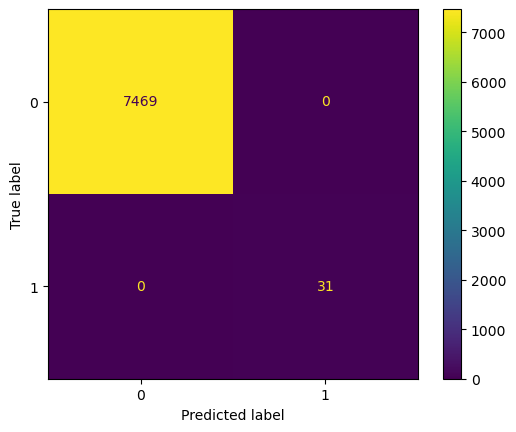

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_train, cred_model.predict(X_train_sc))).plot();

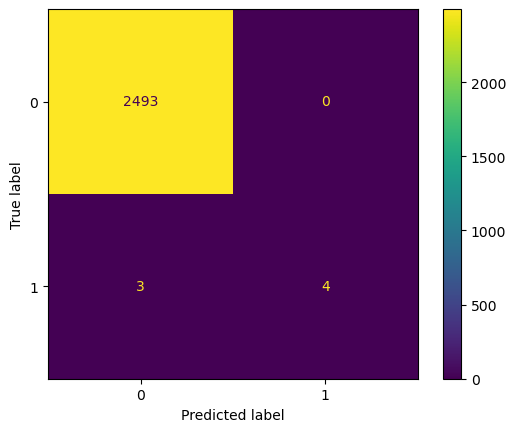

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, cred_model.predict(X_test_sc))).plot();

In [17]:
recall_score(y_test, cred_model.predict(X_test_sc))

0.5714285714285714

In [25]:
log_strong = LogisticRegression(random_state=42, C=.01)
log_strong.fit(X_train, y_train)

/Users/nathan/opt/anaconda3/envs/learn-env-test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, random_state=42)

/Users/nathan/opt/anaconda3/envs/learn-env-test/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


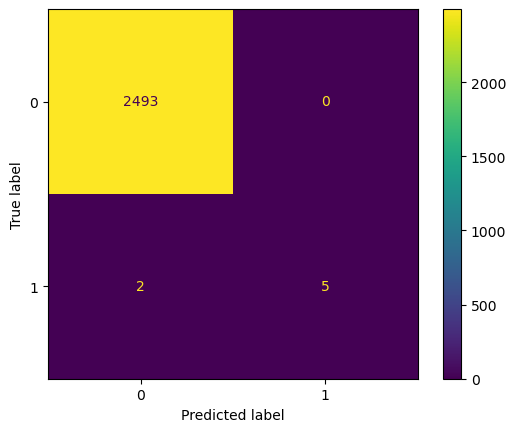

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, log_strong.predict(X_test_sc))).plot();

#### Discuss: What do you notice?

- high acc is misleading, missing almost half of the true fraud cases, not good
- we care more about recall then acc

## Class Imbalance

In [27]:
# What does a class imbalance look like?
y_train.value_counts()

Class
0    7469
1      31
Name: count, dtype: int64

### Why do we care?

Think about it - you're asking a computer, which has NO idea what you're talking about or how to identify anything in any way other than how you tell it to identify things, to look at something completely new and categorize it. If you feed it 1000 emails, 950 of which are 'not spam' and 50 of which are 'spam,' and ask it to identify which are 'not spam,' it can just label everything as 'not spam' and be 95% correct! Not bad!

And yet... that doesn't do what you want at all. You want your model to learn the characteristics of 'spam' emails and actually identify the parts of it which are reliable predictors for 'spam' in general, something the computer is increasingly incentivized not to do as the majority in your datasets gets larger compared to the minority. If your target is really imbalanced, your model will have to work increasingly harder in order to do better than the model-less baseline of just predicting the majority class.

## What can we do about it?

### Under-Sampling

Basically, take a sample to reduce the majority class to be the same size as the minority class.

Example:
```
minority = df.loc[df["category"] == "minority"]
majority = df.loc[df["category"] == "majority"].sample(n=len(minority))
```

Problems?

- Losing a lot of observations (in the 50 spam vs 950 not-spam example, we'd lose 900 rows!)


### Over-Sampling

The opposite - keep resampling from our minority class until it's the same size as the majority class.

Example:
```
majority = df.loc[df["category"] == "majority"]
minority = df.loc[df["category"] == "minority"].sample(n=len(majority), replace=True)
```

Problems?

- Will over-fit to the minority class, since it'll see the same minority examples over and over again (in the same 50 spam vs 950 not-spam example, we'd likely repeat each of the rows in the minority class 19 times!)


### Split The Difference

Basically, balance Under and Over sampling so that you do a bit of both - might be better than relying on just one of the above strategies.

### Implementing Over-Sampling

In [28]:
# First, train test split
# We only implement these techniques on training data!
X = data.drop(columns='Class')
y = data['Class']

X_tr_samp, X_te_samp, y_tr_samp, y_te_samp = train_test_split(
    X, y, test_size=.25, random_state=1)

In [29]:
# Need to put our training data back together
train_data = X_tr_samp.copy()
train_data['Class'] = y_tr_samp
train_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
651,492.0,-0.789890,-1.379371,0.171334,-1.636756,-2.807266,0.726236,2.737602,-0.933999,-2.413730,...,-0.256231,0.167077,0.540876,0.067496,0.479636,-0.098230,0.053527,-0.408050,632.40,0
6560,7949.0,-0.944392,1.120606,1.943698,0.438131,0.357940,-0.524502,0.527956,-0.234039,0.785934,...,-0.412873,-0.845279,-0.195698,0.212402,-0.030611,0.138765,-0.189770,-0.062716,3.59,0
8974,12399.0,1.168740,-0.180544,0.741365,0.283013,-0.611288,-0.057707,-0.511689,0.094057,1.881734,...,-0.181691,-0.053286,0.004593,0.247339,0.270206,1.075329,-0.084131,-0.019860,3.30,0
2348,1892.0,-2.183004,-0.401099,0.864277,1.256849,0.797138,-1.377806,0.372290,-0.286859,0.095818,...,-0.098498,0.477961,0.509126,0.388621,-0.052237,-0.316810,-0.024000,0.568065,21.50,0
5670,5930.0,-1.788635,-1.712669,0.986718,-1.975763,2.219729,-1.987765,-0.805166,0.061549,1.989917,...,0.104806,-0.087014,0.216295,-0.540503,-0.149504,-0.229080,0.006315,0.167245,26.64,0


In [30]:
len(train_data)

7500

In [31]:
# Let's try over-sampling our minority class and see how we do
# Copy the provided code above, then adjust to our context
majority = train_data.loc[train_data['Class'] == 0]
minority = train_data.loc[train_data['Class'] == 1].sample(n=len(majority), replace=True)

# Then use pd.concat to combine, resetting the index using .reset_index(drop=True)
oversampled_train = pd.concat([majority, minority]).reset_index(drop=True)
oversampled_train.shape

(14938, 31)

In [32]:
# Split out oversampled_train back out into X and y
X_tr_oversamp = oversampled_train.drop(columns="Class")
y_tr_oversamp = oversampled_train['Class']

In [33]:
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_tr_oversamp)
X_tr_over_sc = scaler.transform(X_tr_oversamp)
X_te_sc = scaler.transform(X_te_samp)

# Train a logistic regresssion model with the train data
over_model = LogisticRegression(random_state=42)
over_model.fit(X_tr_over_sc, y_tr_oversamp)

LogisticRegression(random_state=42)

In [34]:
over_model.score(X_tr_over_sc, y_tr_oversamp)

1.0

In [35]:
over_model.score(X_te_sc, y_te_samp)

0.9988

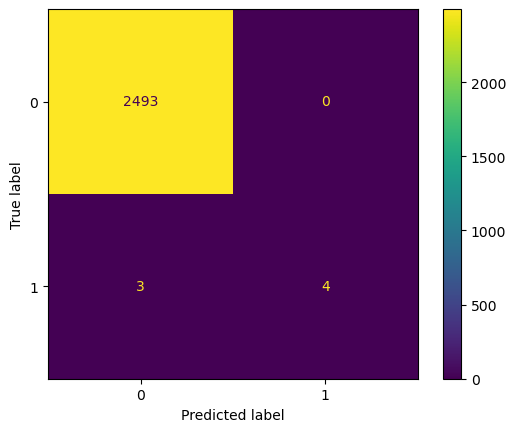

In [36]:
ConfusionMatrixDisplay(confusion_matrix(y_te_samp, over_model.predict(X_te_sc))).plot();

#### Discuss:

- Only predicted one more true positive, not really imporved much


### Synthetic Data Creation - ADASYN and SMOTE

The **Synthetic Minority Oversampling Technique (SMOTE)** conducts cluster-based over-sampling. SMOTE works by finding all the instances of the minority category within the observations, drawing lines between those instances, and then creating new observations along those lines.

![SMOTE visualized](images/SMOTE_R_visualisation_3.png)

Image source is a great explainer on SMOTE (but uses R for the examples): https://rikunert.com/SMOTE_explained

This is better than simply using a random over-sample, yet not only are these synthetic samples not real data but also these samples are based on your existing minority. So, those new, synthetic samples can still result in over-fitting, since they're made from our original minority category. An additional pitfall you might run into is if one of your minority category is an outlier - you'll have new data that creates synthetic data based on the line between that outlier and another point in your minority, and maybe that new synthetic data point is also an outlier.

Another way to create synthetic data to over-sample our minority category is the **Adaptive Synthetic approach, ADASYN**. ADASYN works similarly to SMOTE, but it focuses on the points in the minority cluster which are the closest to the majority cluster, aka the ones that are most likely to be confused, and focuses on those. It tries to help out your model by focusing on where it might get confused, where 'spam' and 'not spam' are the closest, and making more data in your 'spam' minority category there.


Check out the library [imblearn](https://imbalanced-learn.org/stable/) for implementation of these!

### Implementing SMOTE:

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Reminder: go back to our original train/test split:

```
X_tr_samp, X_te_samp, y_tr_samp, y_te_samp
```

In [37]:
# New import - note, not SKLearn!
from imblearn.over_sampling import SMOTE

In [38]:
# Still need to scale why do you think that is?
scaler = StandardScaler()
scaler.fit(X_tr_samp)
X_tr_sc = scaler.transform(X_tr_samp)
X_te_sc = scaler.transform(X_te_samp)

In [39]:
# Instantiate our SMOTE
sm = SMOTE(random_state=42)
# Fit and resample on the training data! X_tr_samp, y_tr_samp
X_tr_smote, y_tr_smote = sm.fit_resample(X_tr_sc, y_tr_samp)

In [40]:
X_tr_sc.shape

(7500, 30)

In [41]:
X_tr_smote.shape

(14938, 30)

In [42]:
# Train a logistic regresssion model with the train data
smote_model = LogisticRegression(random_state=42)
smote_model.fit(X_tr_smote, y_tr_smote)

LogisticRegression(random_state=42)

In [43]:
smote_model.score(X_te_sc, y_te_samp)

0.9996

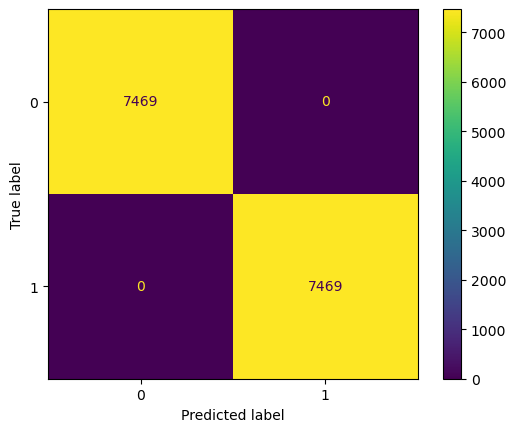

In [44]:
ConfusionMatrixDisplay(confusion_matrix(y_tr_smote, smote_model.predict(X_tr_smote))).plot();

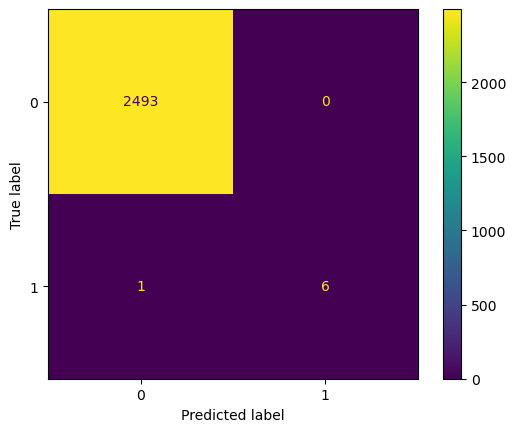

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_te_samp, smote_model.predict(X_te_sc))).plot();

In [46]:
recall_score(y_te_samp, smote_model.predict(X_te_sc))

0.8571428571428571

#### Discuss:

- recall imporved significantly, picking up almost all of the actual fraud in test data

### One More Trick: `class_weight='balanced'`

And then, of course, sklearn has some methods to handle imbalanced datasets built right into some models - including logistic regression!

Check out the documentation to find it: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Reminder: go back to our original train/test split:

```
X_tr_samp, X_te_samp, y_tr_samp, y_te_samp
```

In [47]:
# Let's try a model with an adjusted hyperparameter...
logreg_b = LogisticRegression(class_weight='balanced')

In [48]:
# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_tr_samp)
X_tr_sc = scaler.transform(X_tr_samp)
X_te_sc = scaler.transform(X_te_samp)

# Now, fitting our model and grabbing our training and testing predictions
logreg_b.fit(X_tr_sc, y_tr_samp)

train_preds = logreg_b.predict(X_tr_sc)
test_preds = logreg_b.predict(X_te_sc)

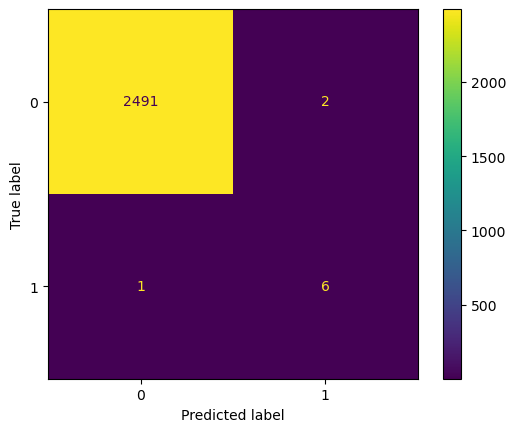

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_te_samp, logreg_b.predict(X_te_sc))).plot();

In [50]:
# Printing the metrics nicely
metrics = {"Accuracy": accuracy_score,
           "Recall": recall_score,
           "Precision": precision_score,
           "F1-Score": f1_score}

for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_tr_samp, train_preds):.4f}")
    print(f"TEST: {metric(y_te_samp, test_preds):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 1.0000
TEST: 0.9988
***************
Recall:
TRAIN: 1.0000
TEST: 0.8571
***************
Precision:
TRAIN: 1.0000
TEST: 0.7500
***************
F1-Score:
TRAIN: 1.0000
TEST: 0.8000
***************


## Resources:

- [SMOTE Explained for Noobs](https://rikunert.com/SMOTE_explained) (the R tutorial I linked earlier)
- [Resampling Strategies for Imbalanced Datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
- Machine Learning Mastery: [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Handling Imbalanced Datasets in Deep Learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758)

In [ ]:
from imblearn.pipeline import Pipeline

In [ ]:
# Hypothetical pipeline (would need to be imblearn pipeline not sklearn)

smote_pipe = Pipeline(steps=[('ct', col_transformer),
                ('smote', SMOTE(), 
                ('model', LogisticRegression()))])